In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from scipy.stats import zscore
from scipy.spatial.distance import mahalanobis
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [3]:
print(df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [4]:
df.columns = df.columns.str.strip()


In [5]:
df = pd.read_csv('creditcard.csv', header=0)


In [6]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'Amount']
X = df[features]
y = df['Class']

In [7]:
X = df.reindex(columns=features, fill_value=0)


In [8]:
missing_columns = [col for col in features if col not in df.columns]
print("Missing columns:", missing_columns)

Missing columns: []


In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

In [10]:
X_scaled.head()

,V1,V2,V3,V4,V5,V6,Amount
0,-0.586840,-0.019228,1.386468,0.896682,-0.042554,0.282655,0.188520
1,0.778415,0.184421,-0.380022,0.210384,0.248485,-0.135223,-0.359014
2,-0.586063,-0.780739,0.817628,0.159926,-0.163018,1.309123,1.042035
3,-0.376281,-0.086791,0.832375,-0.757403,0.197102,0.884688,0.091184
4,-0.478989,0.551894,0.650293,0.177087,-0.092874,0.001538,-0.108221


In [11]:
z_scores = np.abs(zscore(X_scaled))
z_score_outliers = (z_scores > 3).any(axis=1)

print("Z-score Outliers:", np.sum(z_score_outliers))

Z-score Outliers: 3942


In [12]:
X_scaled = X_scaled.dropna()

In [13]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_scaled = imputer.fit_transform(X_scaled)


In [14]:
import numpy as np

X_scaled = np.nan_to_num(X_scaled, nan=0)


In [15]:
from sklearn.covariance import EllipticEnvelope

elliptic_env = EllipticEnvelope(contamination=0.05)
mah_outliers = elliptic_env.fit_predict(X_scaled) == -1

print("Mahalanobis Outliers:", np.sum(mah_outliers))


Mahalanobis Outliers: 4659


In [16]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_outliers = lof.fit_predict(X_scaled) == -1

print("LOF Outliers:", np.sum(lof_outliers))

LOF Outliers: 4659


In [17]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_outliers = iso_forest.fit_predict(X_scaled) == -1

print("Isolation Forest Outliers:", np.sum(iso_outliers))

Isolation Forest Outliers: 4659


In [18]:
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
svm_outliers = oc_svm.fit_predict(X_scaled) == -1

print("One-Class SVM Outliers:", np.sum(svm_outliers))


One-Class SVM Outliers: 4660


In [19]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_true = df['Class']
y_true = y_true.dropna()
y_true = y_true.values

results = []

def evaluate_model(anomalies_detected, method_name, y_true_global):

    y_pred = anomalies_detected.astype(int)

    y_true = y_true_global
    min_length = min(len(y_true), len(y_pred))
    y_true = y_true[:min_length]
    y_pred = y_pred[:min_length]

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    results.append([method_name, accuracy, precision, recall, f1])

evaluate_model(z_score_outliers, "Z-score", y_true)
evaluate_model(mah_outliers, "Mahalanobis Distance", y_true)
evaluate_model(lof_outliers, "LOF", y_true)
evaluate_model(iso_outliers, "Isolation Forest", y_true)
evaluate_model(svm_outliers, "One-Class SVM", y_true)

results_df = pd.DataFrame(results, columns=["Method", "Accuracy", "Precision", "Recall", "F1 Score"])

print("Anomaly Detection Results:")
print(results_df)

Anomaly Detection Results:
                 Method  Accuracy  Precision    Recall  F1 Score
0               Z-score  0.958521   0.036783  0.680751  0.069795
1  Mahalanobis Distance  0.950955   0.032410  0.708920  0.061987
2                   LOF  0.949002   0.012878  0.281690  0.024631
3      Isolation Forest  0.950955   0.032410  0.708920  0.061987
4         One-Class SVM  0.951331   0.036266  0.793427  0.069362


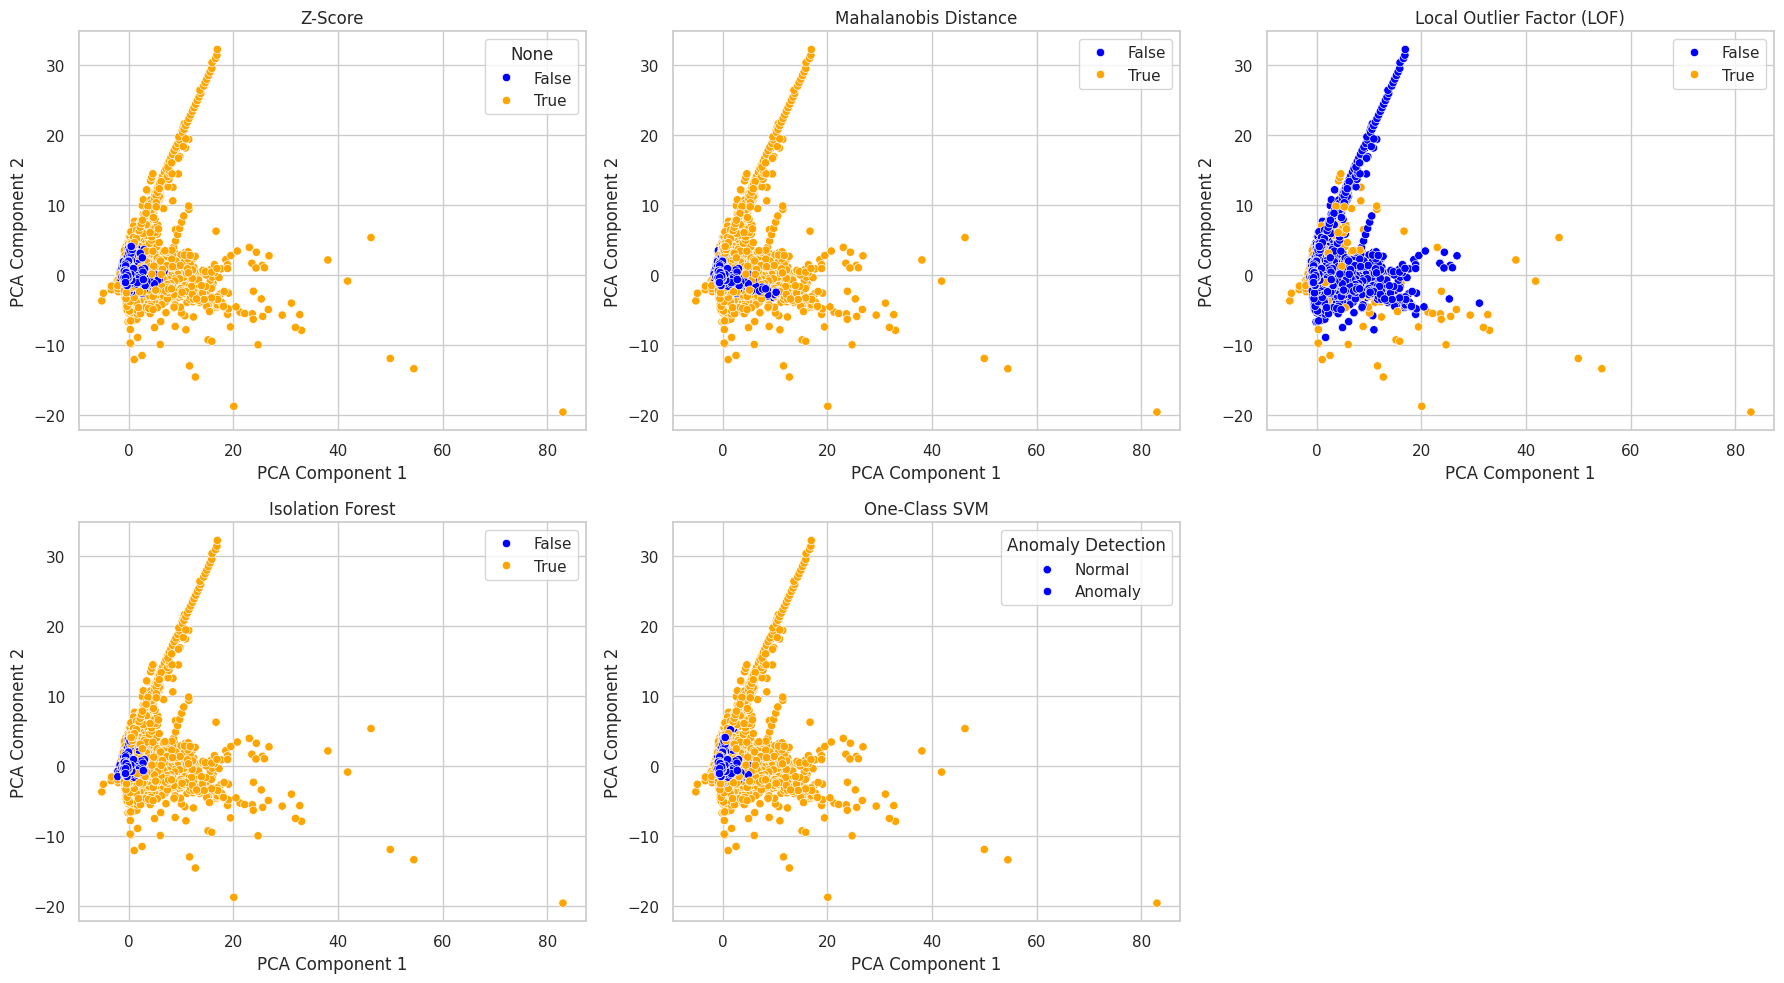

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Perform PCA to reduce features to 2D
pca = PCA(n_components=2)
features_2d = pca.fit_transform(X_scaled)

# Ensure all arrays are of the same length
min_len = min(features_2d.shape[0], len(z_score_outliers), len(mah_outliers),
              len(lof_outliers), len(iso_outliers), len(svm_outliers))

features_2d = features_2d[:min_len]
z_score_outliers = z_score_outliers[:min_len]
mah_outliers = mah_outliers[:min_len]
lof_outliers = lof_outliers[:min_len]
iso_outliers = iso_outliers[:min_len]
svm_outliers = svm_outliers[:min_len]

# Set up the plot
plt.figure(figsize=(18, 10))
sns.set(style="whitegrid")

# Define a custom color palette
palette = {0: 'blue', 1: 'orange'}  # Blue for normal, orange for anomaly

# Plot Z-Score
plt.subplot(2, 3, 1)
plt.title("Z-Score")
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=z_score_outliers, palette=palette)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Plot Mahalanobis Distance
plt.subplot(2, 3, 2)
plt.title("Mahalanobis Distance")
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=mah_outliers, palette=palette)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Plot Local Outlier Factor (LOF)
plt.subplot(2, 3, 3)
plt.title("Local Outlier Factor (LOF)")
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=lof_outliers, palette=palette)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Plot Isolation Forest
plt.subplot(2, 3, 4)
plt.title("Isolation Forest")
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=iso_outliers, palette=palette)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Plot One-Class SVM
plt.subplot(2, 3, 5)
plt.title("One-Class SVM")
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=svm_outliers, palette=palette)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Adjust layout and show the plot
plt.tight_layout()
plt.legend(title="Anomaly Detection", loc="upper right", labels=["Normal", "Anomaly"])
plt.show()
